# SIR model

I skimmed the [wikipedia article](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). I'm pretty sure that makes me an expert epidemiologist now, just like everyone else on the internet these days.

* [SIR model](#SIR-model)
    * [Accounting for lockdown](#Accounting-for-lockdown)
    * [Parameters](#Parameters)
    * [Madrid](#Madrid)
        * [Without lockdown](#Without-lockdown)
        * [With lockdown](#With-lockdown)
* [observed deaths](#observed-deaths)


In [1]:
%matplotlib inline
import numpy as np
from numpy import array

import matplotlib.pyplot as plt

import sir

def plot_sim(sim, ylabel):
    """
    Utility to plot s, i, r populations over a year's time for a given model 
    """
    days = np.arange(365)

    susceptible = sim.get_s(days)
    infected = sim.get_i(days)
    recovered = sim.get_r(days)

    plt.plot(days, susceptible, label="susceptible")
    plt.plot(days, infected, label="infected")
    plt.plot(days, recovered, label="recovered")
    plt.legend(loc="upper left")
    plt.xlabel("days")
    plt.ylabel(ylabel)

## SIR model

[Wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics) does a better job of explaining it than I would; SIR models 3 distinct populations through time:
* susceptible: those who have not yet been exposed
* infected: those who have been exposed and are infectious
* recovered: those who are no longer contagious or susceptible. Recovered means no longer contagious, **a death is counted as recovered in the model**.

I've implemented a trivial numerical integrator for the model's differential equations, the code is in `sir.py`.

### Accounting for lockdown

The vanilla SIR model has constant $\beta$ and $\gamma$ parameters: we need to take into account a lockdown, which (hopefully!) introduces a radical change in the $\beta$ parameter when the lockdown is implemented.

### Parameters

So our SIR model with lockdowns has the following parameters:

* $state_0$ S, I, R populations at time 0
* $\beta_0$ beta before lockdown
* $\beta_1$ beta after lockdown
* $t\_lock$ time at which lockdown occurs
* $\gamma$ gamma

### Madrid

As an example, let's plot a simulation, carefully choosing values to aid our intuition based on published data on covid-19.

We'll simulate a disease like covid-19: with an $R_0 = 2.5$, with a mean time to infection resolution of 20 days, for a year in a city the size of Madrid:

* our time unit is a day
* $p_0$ total population at time 0 is 6.55 million people
* $i_0$ total infected at time 0, let's say 1000 individuals
* $r_0$ total recovered at time 0 is 0
* $\gamma$ its inverse is typical time to resolution, according to wiki, so: let's say this is 20 days: $\gamma = 1/20$

#### Without lockdown

R0 (and beta) is constant throughout in this scenario:

In [2]:
def get_sim():
    R0 = 2.5
    gamma = 1 / 20.
    kbeta = R0 * gamma
    state0 = array([6.55 * 1000000, 1000, 0])

    beta = sir.Beta(kbeta, kbeta, 0)

    return sir.SIR(beta, gamma, state0)

#### With lockdown

R0 is drastically reduced to 0.9 on day 70, when lockdown measures are introduced:

In [3]:
def get_sim_lockdown():
    R0_pre_lockdown = 2.5
    R0_post_lockdown = 0.9
    gamma = 1 / 20.
    beta0 = R0_pre_lockdown * gamma
    beta1 = R0_post_lockdown * gamma
    t_lock = 70

    state0 = array([6.55 * 1000000, 1000, 0])

    beta = sir.Beta(beta0, beta1, t_lock)

    return sir.SIR(beta, gamma, state0)

sim = get_sim()
sim_lockdown = get_sim_lockdown()

Let's plot the lockdown and no-lockdown simulations and compare the number of infections through time:

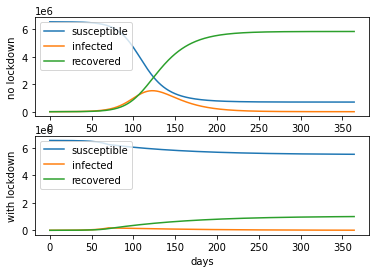

In [4]:
plt.subplot(2, 1, 1)
plot_sim(sim, "no lockdown")
plt.subplot(2, 1, 2)
plot_sim(sim_lockdown, "with lockdown")
plt.show()

Considering the number of deaths is proportional to the confusingly-named `recovered` population, the situation after implementing lockdown measures looks much better!

## observed deaths

The SIR model's variables are not directly observable, at least not until widespread testing is available.

Let's use our models to calculate daily deaths: to do this, we'll need:
* daily recoveries, where daily recoveries at day i is defined as all recoveries occurring from day i-1 to day i. **Remeber that in a SIR model, recovered = dead + cured**
* $\alpha$, the infection fatality rate: let's set this at 0.8%

These numbers actually look in the ballpark for Madrid, unfortunately, and again the lockdown situation looks much, much better:

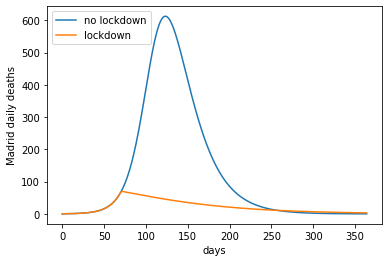

In [5]:
alpha = 0.008
sim_recoveries = sir.Recoveries(sim)
sim_lockdown_recoveries = sir.Recoveries(sim_lockdown)

days = np.arange(365)

recs = np.array([sim_recoveries(day) for day in days])
lockdown_recs = np.array([sim_lockdown_recoveries(day) for day in days])

plt.plot(days, alpha * recs, label="no lockdown")
plt.plot(days, alpha * lockdown_recs, label="lockdown")
plt.legend(loc="upper left")
plt.xlabel("days")
plt.ylabel("Madrid daily deaths")
plt.show()



Daily deaths are an observed variable: they are reported in the news.

Basically, the number of deaths in a given day is a random variable dependent on $\alpha$ and on the SIR models unobserved recovery count:

$$
P(deaths[i] \mid \alpha, recovered[i])
$$